# pop_bilateral filter with just in time compilation and nogil
Benchmark of scikit-image's pop_bilateral filter (rank cython) vs python jit with numba. 

Numba also allows for easy multiprocessing with releasing the global intepreter lock.

In [1]:
%matplotlib inline
from numba import jit
import numpy as np
from skimage.io import imread, imshow
from skimage.filters.rank import pop_bilateral
from skimage.morphology import square

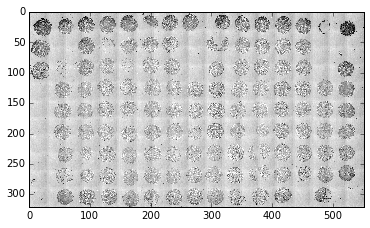

In [2]:
img = imread('data/experiment--2015_05_04_19_28_38_equalized/stitched--U00--V00--C00--Z00.png')
imshow(img[::16, ::16])

### skimage pop

In [3]:
%time pop_sk = pop_bilateral(img, square(9))

CPU times: user 20.1 s, sys: 479 ms, total: 20.6 s
Wall time: 21 s


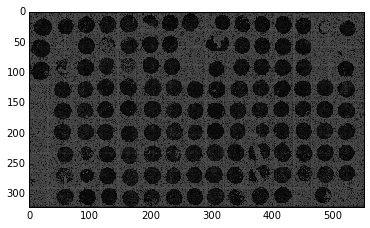

In [4]:
imshow(pop_sk[::16, ::16])

In [5]:
@jit(nogil=True, nopython=True)
def _pop_bilateral_numba(img, selem_size, out, s0=10, s1=10):
    """
    Parameters
    ----------
    img : 2d array
        Padded image.
    selem_size : int
        Size of square selem.
    out : 2d array
        Array to store result to (nopython, nogil).
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            val = img[i+pad, j+pad]
            o = 0
            for ii in range(selem_size):
                for jj in range(selem_size):
                    diff = img[i+ii, j+jj] - val
                    if diff >= -s0 and diff <= s1:
                        o += 1
            out[i, j] = o # cheaper than accessing array in each inner loop

def pop_bilateral_numba(img, selem, s0=10, s1=10):
    """
    Parameters
    ----------
    img : 2d array
        Padded image.
    selem : 2d array
        Selem. Only y-shape will be considered, resulting in a square selem.
    s0 : int
        Lower bound.
    s1 : int
        Higher bound.
    """
    img = img.astype(np.int16) # avoid overrun when calculating diff
    pad = selem.shape[0]//2 # square selem for now
    selem_size = 2*pad
    img = np.pad(img, pad, mode='edge') # nopython, nogil
    out = np.zeros(img.shape, dtype=np.uint8) # nopython, nogil
    _pop_bilateral_numba(img, selem_size, out, s0, s1)
    return out

### numba pop

In [6]:
%time pop_nb = pop_bilateral_numba(img, square(9))

CPU times: user 11.7 s, sys: 598 ms, total: 12.3 s
Wall time: 12.8 s


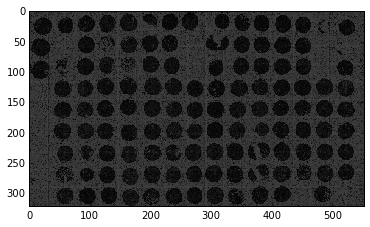

In [8]:
imshow(pop_nb[::16, ::16])

In [7]:
_pop_bilateral_numba.inspect_types()

_pop_bilateral_numba (array(int16, 2d, C), int64, array(uint8, 2d, C), int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-5-acd574b8d16d>
# --- LINE 1 --- 

@jit(nogil=True, nopython=True)

# --- LINE 2 --- 

def _pop_bilateral_numba(img, selem_size, out, s0=10, s1=10):

    # --- LINE 3 --- 

    """

    # --- LINE 4 --- 

    Parameters

    # --- LINE 5 --- 

    ----------

    # --- LINE 6 --- 

    img : 2d array

        # --- LINE 7 --- 

        Padded image.

    # --- LINE 8 --- 

    selem_size : int

        # --- LINE 9 --- 

        Size of square selem.

    # --- LINE 10 --- 

    out : 2d array

        # --- LINE 11 --- 

        Array to store result to (nopython, nogil).

    # --- LINE 12 --- 

    s0 : int

        # --- LINE 13 --- 

        Lower bound.

    # --- LINE 14 --- 

    s1 : int

        # --- LINE 15 --- 

        Higher bound.

    # --- LINE 16 --- 

    """

    # --- LINE 17 --

In [9]:
from math import ceil
from multiprocessing import cpu_count
import dask.array as da

def _get_chunks(shape, ncpu):
    """
    Split the array into equal sized chunks based on the number of
    available processors. The last chunk in each dimension absorbs the
    remainder array elements if the number of cpus does not divide evenly into
    the number of array elements.
    >>> _get_chunks((4, 4), 4)
    ((2, 2), (2, 2))
    >>> _get_chunks((4, 4), 2)
    ((2, 2), (4,))
    >>> _get_chunks((5, 5), 2)
    ((2, 3), (5,))
    >>> _get_chunks((2, 4), 2)
    ((1, 1), (4,))
    """
    chunks = []
    nchunks_per_dim = int(ceil(ncpu ** (1./len(shape))))

    used_chunks = 1
    for i in shape:
        if used_chunks < ncpu:
            regular_chunk = i // nchunks_per_dim
            remainder_chunk = regular_chunk + (i % nchunks_per_dim)

            if regular_chunk == 0:
                chunk_lens = (remainder_chunk,)
            else:
                chunk_lens = ((regular_chunk,) * (nchunks_per_dim - 1) +
                              (remainder_chunk,))
        else:
            chunk_lens = (i,)

        chunks.append(chunk_lens)
        used_chunks *= nchunks_per_dim
    return tuple(chunks)


def apply_chunks(function, array, chunks=None, depth=0, mode=None,
                 extra_arguments=(), extra_keywords={}):
    """Map a function in parallel across an array.
    Split an array into possibly overlapping chunks of a given depth and
    boundary type, call the given function in parallel on the chunks, combine
    the chunks and return the resulting array.
    Parameters
    ----------
    function : function
        Function to be mapped which takes an array as an argument.
    array : numpy array
        Array which the function will be applied to.
    chunks : int, tuple, or tuple of tuples, optional
        A single integer is interpreted as the length of one side of a square
        chunk that should be tiled across the array.  One tuple of length
        ``array.ndim`` represents the shape of a chunk, and it is tiled across
        the array.  A list of tuples of length ``ndim``, where each sub-tuple
        is a sequence of chunk sizes along the corresponding dimension. If
        None, the array is broken up into chunks based on the number of
        available cpus. More information about chunks is in the documentation
        `here <https://dask.pydata.org/en/latest/array-design.html>`_.
    depth : int, optional
        Integer equal to the depth of the added boundary cells. Defaults to
        zero.
    mode : 'reflect', 'periodic', 'wrap', 'nearest', optional
        type of external boundary padding
    extra_arguments : tuple, optional
        Tuple of arguments to be passed to the function.
    extra_keywords : dictionary, optional
        Dictionary of keyword arguments to be passed to the function.
    """
    if chunks is None:
        shape = array.shape
        ncpu = cpu_count()
        chunks = _get_chunks(shape, ncpu)

    if mode == 'wrap':
        mode = 'periodic'

    def wrapped_func(arr):
        return function(arr, *extra_arguments, **extra_keywords)

    darr = da.from_array(array, chunks=chunks)
    return darr.map_overlap(wrapped_func, depth, boundary=mode).compute()

### parallel pop

In [10]:
%time pop_da = apply_chunks(pop_bilateral_numba, img, extra_arguments=(square(9),))

CPU times: user 18 s, sys: 992 ms, total: 19 s
Wall time: 7.02 s


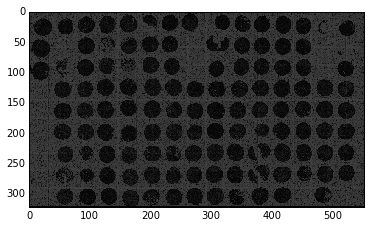

In [11]:
imshow(pop_da[::16, ::16])